In [98]:
import sys
import re
import pandas as pd
import os
from os import walk
from pathlib import Path
from functools import reduce
from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt

In [99]:
ROOT_PATH = "/Users/janschill/code/rails/rails"

In [100]:
def full_path(file_name):
    return ROOT_PATH + file_name

In [101]:
# Number of lines
def number_of_lines(file):
    return sum([1 for line in open(file)])

In [102]:
def extract_from_line(name, line):
    if re.search("^([\s]*#)", line): # ignore comments
        return None
    elif name == 'def|end':
        method = re.search("^([\s]*(def |end)[ (\S+)]*)", line)
        return str(method.group(1)) if method else None
    elif name == 'module|class|end':
        namespace = re.search("^([\s]*(module|class|end)[ (\S+)]*)", line)
        return str(namespace.group(1)) if namespace else None
    else:
        x = re.search("" + name + " (\S+)", line)
        return None if x == None else str(x.group(1))

In [103]:
def extract(file, keyword, all_lines = False):
    extracts = []
    if os.path.isfile(file):
        for line in open(file):
            extract = extract_from_line(keyword, line)
            if extract or all_lines:
                extracts.append(extract)
    return extracts

In [104]:
def extract_require(file):
    extracts = extract(file, 'require')
    return [x.replace('"', '') for x in extracts]

def extract_modules(file):
    return extract(file, 'module')

def extract_classes(file):
    return extract(file, 'class')

def extract_add_dependecy(file):
    return extract(file, 'add_dependency')

def extract_autoload(file):
    extracts = extract(file, 'autoload')
    extracts = [ex for ex in extracts if ',' not in ex]
    extracts = [ex for ex in extracts if ':' in ex]
    return [x.replace(':', '') for x in extracts]

In [105]:
def clean_namespace(namespace):
    return namespace.replace('module', '').replace('class', '').replace(' ', '')

# Still does not work properly
# It does not add correctly when inline class
# Idea: add new namespace for every new encounter of module of class
def extract_namespace(file):
    namespaces = []
    namespace = []
    previous_identation = -1
    for line in open(file):
        extract = extract_from_line('module|class|end', line)
        if extract == None:
            continue
        else:
            if 'end' in extract and (len(extract) - len(extract.lstrip(' ')) == previous_identation):
                namespaces.append(namespace.copy())
            elif 'module' in extract or 'class' in extract:
                current_identation = len(extract) - len(extract.lstrip(' '))
                module_or_class = 'module' if 'module' in extract else 'class'
                name = extract.split(module_or_class, maxsplit=1)[-1].split(maxsplit=1)[0]
                current_namespace = clean_namespace(name)
                if current_identation > previous_identation:
                    namespace.append(current_namespace)
                elif current_identation < previous_identation:
                    del namespace[-1]
                    if len(namespace) > 0:
                        del namespace[-1]
                    namespace.append(current_namespace)
                else:
                    del namespace[-1]
                    namespace.append(current_namespace)
                previous_identation = current_identation
            else:
                continue
    return namespaces

In [106]:
extract_namespace('/Users/janschill/code/rails/rails/actioncable/lib/action_cable.rb')

[['ActionCable', '_function']]

In [107]:
def retrieve_function_name(func):
    function_name = re.search("def (\S+)", func)
    return function_name.group(1)

def add_function(function_name, line_count):
    return {
        'function_name': function_name,
        'line_count': line_count,
    }

# TODO: This does not do nested functions ATM
def extract_functions(file):
    functions = []
    line_count = 1
    current_function_name = ''
    def_identation = -1
    for ext in extract(file, 'def|end', True):
        if ext == None: # None, increment line_count
            line_count += 1
        else:
            identation = len(ext) - len(ext.lstrip(' '))
            if 'def ' in ext and ' end' in ext:
                current_function_name = retrieve_function_name(ext)
                functions.append(add_function(current_function_name, 1))
            elif 'def ' in ext:
                def_identation = identation
                line_count = 0
                current_function_name = retrieve_function_name(ext)
            elif 'end' in ext and identation == def_identation:
                functions.append(add_function(current_function_name, line_count))
                current_function_name = ''
                line_count = 1
            else:
                line_count += 1
    return functions

In [108]:
def number_of(file, keyword):
    return sum([1 for line in open(file) if extract_from_line(keyword, line)])

def number_of_modules(file):
    return number_of(file, 'module')

def number_of_functions(file):
    return number_of(file, 'def')

def number_of_requires(file):
    return number_of(file, 'require')

In [109]:
# Add all directories from repository root
directories = []
for (dirpath, dirnames, filenames) in walk(ROOT_PATH):
    directories.extend(dirnames)
    break
directories = list(filter(lambda x: x[0] != ".", directories)) # don't use hidden dirs

## Add information to files

In [110]:
def reduce_by_key(list, key):
    sum = 0
    for el in list:
        sum = sum + el[key]
    return sum

In [123]:
def avg_func_length(functions):
    if len(functions) > 0:
        return int(reduce_by_key(functions, 'line_count') / len(functions))
    return 0
    
def get_files(path, file_extension):
    files = Path(path).rglob("*." + file_extension)
    meta_data_files = {}
    for file in files:
        meta_data_files[str(file)] = {
            'filename': str(file),
            'no_lines': number_of_lines(file),
            'no_modules': number_of_modules(file),
            'no_functions': number_of_functions(file),
            'functions': extract_functions(file),
            'average_function_length': avg_func_length(extract_functions(file)),
            'no_requires': len(extract_require(file)),
            'requires': extract_require(file),
            'namespace': extract_namespace(file),
            'autoloads': extract_autoload(file)
        }
    return meta_data_files

In [112]:
def clean_dependency(dependency):
    return dependency.replace('"', '').replace(',', '')

def get_external_dependencies(directory):
    gemspec_file = full_path('/' + directory + '/' + directory + '.gemspec')
    dependencies = extract_add_dependecy(gemspec_file)
    return [clean_dependency(d) for d in dependencies]

## Add information to gems

In [139]:
rails_components = {}
for directory in directories:
    files = get_files(full_path('/' + directory + '/'), 'rb')
    average_LOC = int(reduce_by_key(files.values(), 'no_lines') / len(files.values()))
    average_NOF = int(reduce_by_key(files.values(), 'no_functions') / len(files.values()))
    average_requires = int(reduce_by_key(files.values(), 'no_requires') / len(files.values()))
    average_function_LOC = int(reduce_by_key(files.values(), 'average_function_length') / len(files.values()))
    dependencies = get_external_dependencies(directory)
    rails_components[directory] = {
        'files': files,
        'average_LOC': average_LOC,
        'average_NOF': average_NOF,
        'average_function_LOC': average_function_LOC,
        'average_requires': average_requires,
        'dependencies': dependencies }
rails_components = {k: v for k, v in sorted(rails_components.items(), key = lambda item: item[0])}

In [129]:
def print_rails_components():
    format = "{:<15}{:<1}{:<10}{:<1}{:<7}{:<1}{:<11}{:<1}{:<14}{:<1}{:<10}{:<1}{:<10}"
    print(format.format("Component", " | ", "Ruby files", " | ", "Ø LOC", " | ", "Ø Functions", " | ", "Ø Function LOC", " | ", "Ø Requires", " | ", "Dependencies"))
    print('----------------+------------+---------+-------------+----------------+------------+-------------')
    for k, v in rails_components.items():
        print(format.format(k, ' | ' , len(v['files']), ' | ', v['average_LOC'], ' | ', v['average_NOF'], ' | ', v['average_function_LOC'], ' | ', v['average_requires'], ' | ', len(v['dependencies'])))

## Rails gems

In [134]:
print_rails_components()

Component       | Ruby files | Ø LOC   | Ø Functions | Ø Function LOC | Ø Requires | Dependencies
----------------+------------+---------+-------------+----------------+------------+-------------
actioncable     | 86         | 79      | 6           | 3              | 1          | 4         
actionmailbox   | 93         | 34      | 1           | 2              | 0          | 6         
actionmailer    | 41         | 140     | 9           | 3              | 1          | 6         
actionpack      | 325        | 202     | 16          | 4              | 1          | 6         
actiontext      | 74         | 35      | 2           | 2              | 0          | 5         
actionview      | 186        | 231     | 18          | 3              | 1          | 5         
activejob       | 118        | 70      | 4           | 2              | 1          | 2         
activemodel     | 130        | 118     | 8           | 4              | 1          | 1         
activerecord    | 853        | 160  

In [137]:
def all_rails_components():
    return [
        'activerecord', 'activesupport',
        'actionpack', 'railties',
        'actionview', 'activemodel',
        'activestorage', 'activejob',
        'actionmailbox', 'actioncable',
        'actiontext', 'actionmailer'
    ]

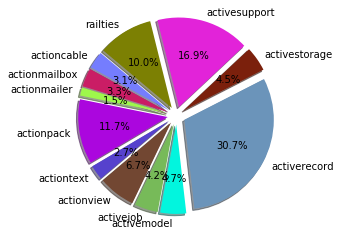

In [172]:
import matplotlib.pyplot as plt
colors = [
  '#757dfe',
  '#ca1d65',
  '#9ef84c',
  '#ab06de',
  '#5642cd',
  '#724732',
  '#77ba59',
  '#02f5de',
  '#6b94ba',
  '#7b200c',
  '#e223d9',
  '#7c8003'
]

# Data to plot
labels = [k for k in rails_components.keys() if k in all_rails_components()]
sizes = [len(v['files']) for k, v in rails_components.items() if k in all_rails_components()]
explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,]
plt.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Lines of code

In [ ]:
def rails_loc():
    RAILS_LOC = 0
    for k,v in rails_components.items():
        for file in v['files'].values():
            RAILS_LOC += file['no_lines']
    return RAILS_LOC

In [ ]:
rails_loc()

In [ ]:
def data_frame_loc():
    components = {}
    no_functions = 0
    for k,v in rails_components.items():
        components[k] = 0
        for file in v['files'].values():
            components[k] += file['no_lines']
            no_functions += file['no_functions']
        rails_components[k]['no_lines'] = components[k] # add total LOC of gem to dic.
        rails_components[k]['no_functions'] = no_functions # add total no. of functions of gem to dic.
        no_functions = 0
    components = {k: v for k, v in sorted(components.items(), key=lambda item: item[1], reverse=True)}
    return components

In [ ]:
RAILS_LOC = rails_loc()
data_frame_loc = data_frame_loc()

df = pd.DataFrame(data_frame_loc, index=['LOC'])
ax = df.plot.barh(figsize=(20,5))

In [ ]:
format = "{:<15}{:<1}{:<6}{:<1}{:<6}"
print(format.format('Component', ' | ', 'LOC', ' | ', 'NOF'))
print('----------------+--------+--------')
for k, v in rails_components.items():
    print(format.format(k, ' | ' , v['no_lines'], ' | ' , v['no_functions']))

In [ ]:
def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')

In [ ]:
format = "{:<35}{:<1}{:<7}{:<1}{:<5}{:<1}{:<5}{:<1}"
print(format.format('Component', ' | ', 'LOC', ' | ', 'NOF', ' | ', 'NOR', ' | '))
print('------------------------------------+---------+-------+-------|')
for k, v in rails_components.items():
    print(format.format(k, ' | ', rails_components[k]['no_lines'], ' | ', rails_components[k]['no_functions'], ' | ', '', ' | '))
    print('------------------------------------+---------+-------+-------|')
    files = sorted(v['files'].values(), key=lambda k: k['no_lines'], reverse=True)
    for f in files[:5]:
        print(format.format(get_filename(f['filename']), ' | ', f['no_lines'], ' | ', f['no_functions'], ' | ', f['no_requires'], ' | '))
    print(format.format('…', ' | ', '-', ' | ', '-', ' | ', '-', ' | '))
    print('------------------------------------+---------+-------+-------|')

In [ ]:
def remove_root_path(path):
    return path.replace(ROOT_PATH + '/', '')

def remove_module_path(path, module):
    return path.replace(module, '')

def remove_filename(path):
    return path.replace(os.path.basename(os.path.normpath(path)), '')

def get_relative_path(path, module):
    return remove_module_path(remove_root_path(remove_filename(path)), module)

def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')

## Component external dependencies

In [ ]:
def module_size(component):
    try:
        return rails_components[component]['no_lines']*0.8 or 100
    except KeyError as e:
        return 100

def dependencies_graph():
    graph = nx.Graph()

    for k, v in rails_components.items():
        component = k
        if component not in graph.nodes and len(v['dependencies']) != 0:
            graph.add_node(component)

        for each in v['dependencies']:
            graph.add_edge(component, each)

    return graph

def draw_graph(graph):
    plt.figure(figsize=(12,10))
    nx.draw(graph, with_labels=True, node_color='lightblue')
    plt.show()

def draw_graph_with_weights(G, weight_function, figsize=(12,10)):
    node_weights = [weight_function(each) for each in G.nodes]
    plt.figure(figsize=figsize)
    nx.draw(G, with_labels=True, node_size=node_weights, node_color='lightblue')
    plt.show()

In [ ]:
graph = dependencies_graph()
draw_graph(graph)

In [ ]:
graph = dependencies_graph()
draw_graph_with_weights(graph, module_size, (40,20))

In [ ]:
def camel_to_snake(s):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', s).lower()

def get_filename_from_path(path):
    return os.path.basename(os.path.normpath(path))

In [ ]:
def get_path_from_filename(component, filename):
    if not '.rb' in filename:
        filename = filename + '.rb'
    return [rails_components[component]['files'][key] for key in rails_components[component]['files'] if filename == get_filename_from_path(key)][0]['filename']

In [ ]:
def file_size(file, component):
    matches = [rails_components[component]['files'][key] for key in rails_components[component]['files'] if file == get_filename_from_path(key)]
    if len(matches) == 1:
        return matches[0]['no_lines']
    else:
        return 1

In [ ]:
module = camel_to_snake(rails_components['activerecord']['files']['/Users/janschill/code/rails/rails/activerecord/lib/active_record.rb']['autoloads'][10])
module = module + '.rb'

print(module)
print(file_size(module, 'activerecord'))
get_path_from_filename('activerecord', module)

In [ ]:
def component_as_file(component):
    prefix = ''
    if 'action' in component:
        prefix = 'action'
    else:
        prefix = 'active'
    return prefix + '_' + component.replace(prefix, '') + '.rb'

In [ ]:
component = 'activerecord'
component_filename = component_as_file(component)
path = get_path_from_filename(component, component_filename)
autoloads = rails_components[component]['files'][path]['autoloads']

In [ ]:
def autoload_graph(component):
    graph = nx.Graph()
    component_filename = component_as_file(component)
    component_path = get_path_from_filename(component, component_filename)
    autoloads = rails_components[component]['files'][component_path]['autoloads']
    graph.add_node(component_filename)
    for autoload in autoloads:
        autoload = camel_to_snake(autoload) + '.rb'
        if autoload not in graph.nodes:
            graph.add_node(autoload)

        graph.add_edge(component_filename, autoload)

    return graph

def draw_graph_with_weights(graph, component, weight_function, figsize=(50,30)):
    node_weights = [weight_function(each, component)*20 for each in graph.nodes]
    plt.figure(figsize=figsize)
    nx.draw(graph, with_labels=True, node_size=node_weights, node_color='lightblue')
    plt.show()

In [ ]:
def is_rails_component(component):
    return 'active' in component or 'action' in component

In [ ]:
components = [(k,v) for k, v in rails_components.items() if is_rails_component(k) ]
for k, v in components:
    draw_graph_with_weights(autoload_graph(k), k, file_size)